In [1]:
%load_ext autoreload
%autoreload 3 --print

In [110]:
import torch as th
import numpy as np
from torch import optim
from torch import nn
from dynrn.rnntasks import DriscollTasks, ExpMin, Uniform
import dynrn.basic_rnns as rnns
from dynrn.viz import util as vu
import matplotlib.pyplot as plt
import scipy.stats
from pathlib import Path
import tqdm
import seaborn as sns

In [99]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
from dynrn.viz.styles import getc
t20 = lambda x: getc(f"seaborn:tab20{x}")
colors, plotter = styles.init_plt(
    '../plots/notebook/driscoll-rnns',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

### MemoryPro

In [103]:
x, y, periods = DriscollTasks.memorypro(n_sessions=70, memory =  ExpMin(1, 0), angle = Uniform(0, 3.14), session_length=100)
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

icolors = [getc('k'), getc('grey'),  t20('b:17'), t20('b:19')]
ocolors = [t20('c:0'), t20('c:2')]

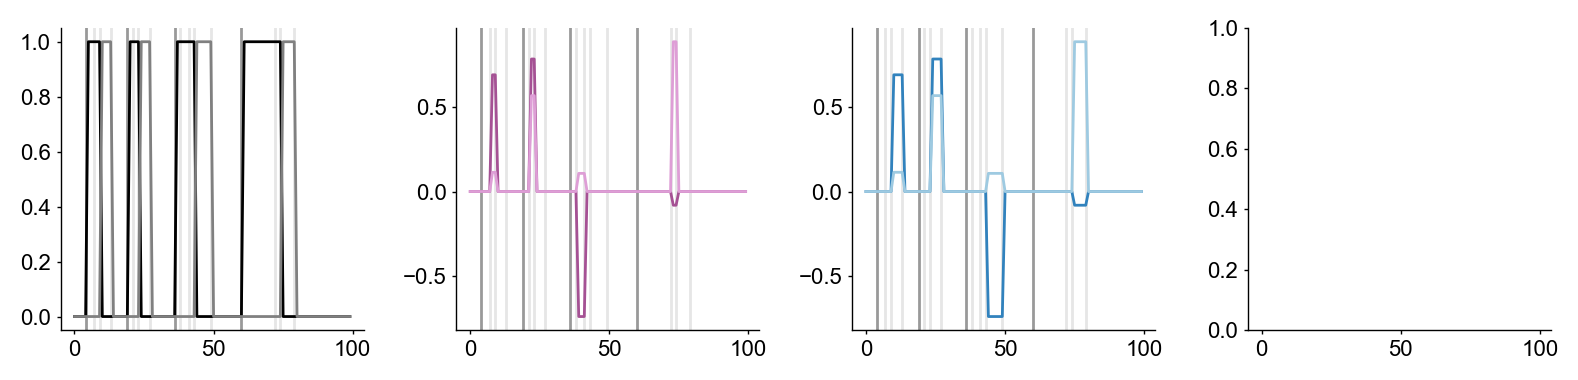

In [104]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex = True)

session = 2
ax[0].plot(x.numpy()[session, :, 0], color = icolors[0])
ax[0].plot(x.numpy()[session, :, 1], color = icolors[1])
ax[1].plot(x.numpy()[session, :, 2], color = icolors[2])
ax[1].plot(x.numpy()[session, :, 3], color = icolors[3])
ax[2].plot(y.numpy()[session, :, 0], color = ocolors[0])
ax[2].plot(y.numpy()[session, :, 1], color = ocolors[1])
for t in np.where(np.diff(periods[session]) != 0)[0]:
    for a in ax[[0, 1, 2]]:
        a.axvline(t, color='.6' if periods[session, t] == 0 else '.9', lw = 1, zorder = -1)

# ax[0].set_xlim(0, 30)
plotter.finalize(fig, None)

##### rnn to perform task

In [113]:
th.manual_seed(0)
rnn = rnns.BasicRNN(x.shape[-1], 200, y.shape[-1], alpha = 0.9, act = nn.Softplus(), bias = True)
with th.no_grad():
    W = scipy.stats.ortho_group.rvs(rnn.nh, random_state=0)
    rnn.h2h.weight.data = th.tensor(W, dtype=th.float32)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-5)
losses, yhats, hs = rnns.fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]


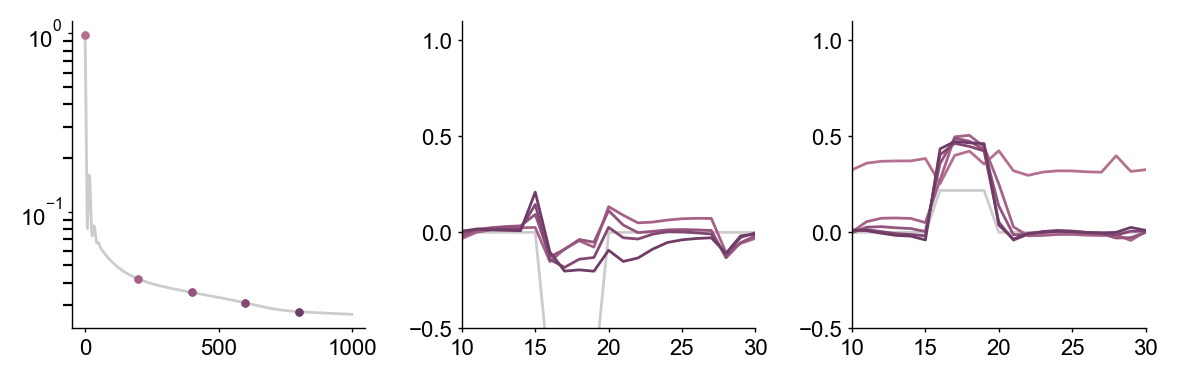

In [112]:
fig, ax = rnns.plot_rnn_training(losses, yhats, y)
for a in ax[1:]:
    a.set_xlim(10, 30)
    a.set_ylim(-0.5, 1.1)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

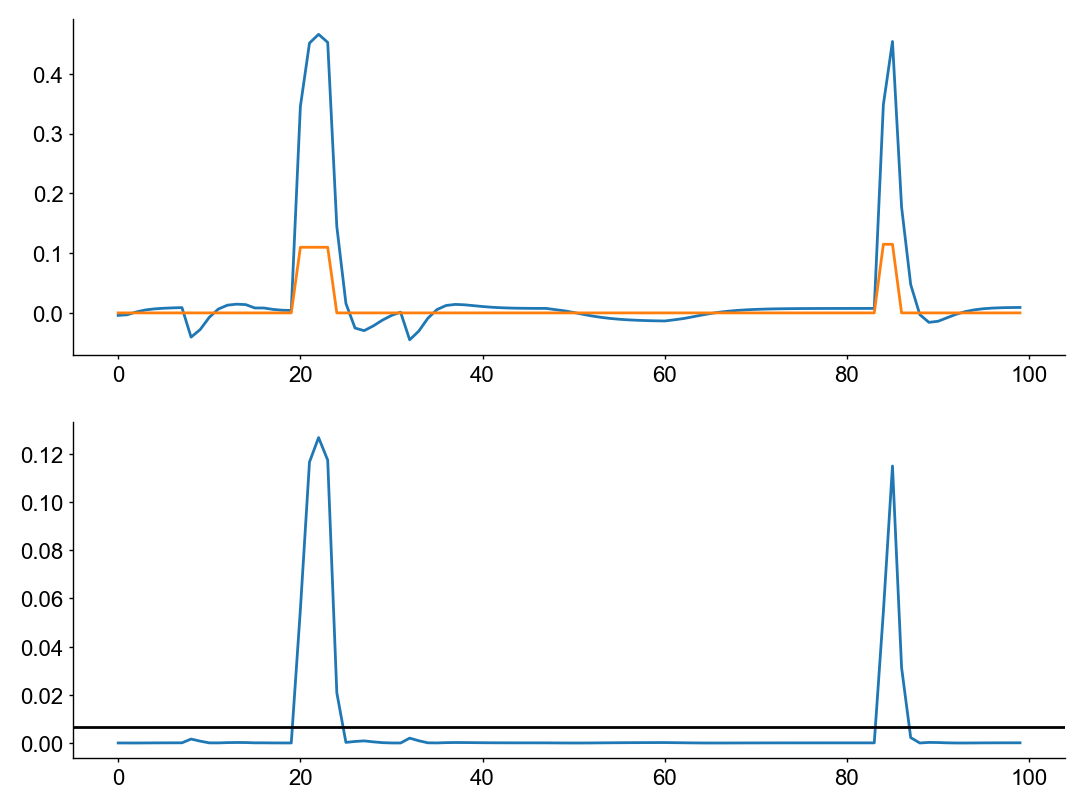

In [84]:
fig, ax = plt.subplots(2,1)
ax[0].plot(yhats[-1, 0, :, 0])
ax[0].plot(y[0, :, 0])
err = (yhats[-1, 0, :, 0] - y.numpy()[0, :, 0]) ** 2
ax[1].plot(err)
ax[1].axhline(err.mean())

